# Kernel Topic Models

### Probabilistic Machine Learning

**Lecturer:** Prof. Philipp Hennig
**Term:** SoSe 2020
**Due Date:** Monday, 19 July, 2020

On this final practical exercise we will once again attempt to infer topics from the state of the union (SOTU) data set. This time however, we combine variational inference with the Laplace bridge and Gaussian process regression to build a *Kernel Topic Model* (https://arxiv.org/abs/1110.4713). 


**Dependencies:**

1. `pip install tqdm, sklearn, scipy, numpy, spacy, matplotlib`
2. `python -m spacy download en_core_web_sm`
3. Make sure you have the following directory structure: `./data/sotu/`

Almost all of the code snippets are provided by us. The only things that you need to implement on this sheet are the initialisation step as well as the Gaussian process part of the update step. Of course, you can always use your own code from the previous sheets instead of what is provided.

In [320]:
import numpy as np
import pickle
import tqdm
from scipy.special import digamma
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import torch
from collections import Counter

Below we extract the data in the same way as in the previous exercises. The only difference is that the words in each document are shuffled before being turned into features. In the top part of this cell, we determine the `MAX_DOC_LEN` and the `VOCAB_SIZE` variable. Both are set to comparably small values, but once you are sure that your topic model is doing what it should, feel free to come back and increase those numbers. The larger the numbers, the more realistic the results are expected to be.

In [321]:
DATA_DIR = './data/'
SOTU_DIR = DATA_DIR + 'sotu/'

# Reduce these values to make things faster, e.g. for debugging
MAX_DOC_LEN = 1000
VOCAB_SIZE = 500

# For a more meaningful output, use larger numbers, e.g.
# 
# MAX_DOC_LEN = 4000
# VOCAB_SIZE = 2000
# 
# so come back here once you are done.

with open(DATA_DIR+'years.bin', 'rb') as f:
    years = pickle.load(f)   # list of years as indices for the docs

with open(DATA_DIR+'preprocessed.bin', 'rb') as f:
    preprocessed_documents = pickle.load(f)   # documents

with open(DATA_DIR+'authors.bin', 'rb') as f:
    authors = pickle.load(f)   # authors

# Preprocess words
count_vect = CountVectorizer(max_features=VOCAB_SIZE, stop_words=['000'])
vocab_per_doc = count_vect.fit_transform(preprocessed_documents)
vocab_per_doc = np.asarray(vocab_per_doc.todense())  # number of occurences of each word (via its index) in the respective doc
word2idx = count_vect.vocabulary_   # {"word": idx_of_this_word_in_total_vocab}
idx2word = count_vect.get_feature_names()  # [word_with_index_0_in_total_vocab, word_with_index_1_in_total_vocab, ...]
num_docs = len(preprocessed_documents)  # num of docs
vocab_size = count_vect.max_features  # vocabulary size
document_feats = np.zeros([num_docs, MAX_DOC_LEN, vocab_size], dtype='int8')  # Dataset

# Create feature matrix
for docidx, doc in enumerate(preprocessed_documents):
    words = []
    
    # shuffle words in document
    doc_splitted_copy = doc.split(' ')
    random.shuffle(doc_splitted_copy)
    
    for word in doc_splitted_copy:
        try:
            idx = word2idx[word]
            words.append(idx)
        except KeyError:
            pass
        
        if len(words) >= MAX_DOC_LEN:
            break
            
    for wordidx, word in enumerate(words):
        document_feats[docidx, wordidx, word] = 1

In the next cell, we provide an implementation of the functions associated with the Laplace bridge, a Gaussian process covariance kernel and some other useful functions. Feel free to replace those with your own code. We propose to use a square exponential kernel for the time variable (i.e. the year of each document) with an additive term that indicates whether the authors of a document are the same. The length scale is set manually and the amplitude of both covariances are chosen such that they match a desired Dirichlet parameterisation $\alpha$. Other parameters/kernels will likely work just as well, so go ahead and try other configurations if you like.

In [322]:
def dir2gauss(alpha):
    """
    Maps a Dirichlet parameterisation (alpha) to 
    a Gaussian parameterisation (mean, var)
    through the Laplace bridge.
    
    This function is not vectorised.
    
    Parameters
    ----------
    alpha : array_like, shape (K,)
        Dirichlet concentration parameter.
    
    Returns
    -------
    mean : array, shape (K,)
        Mean of the Laplace approximation of the Dirichlet
    var : array, shape (K,)
        Variances of the Laplace approximation of the Dirichlet
    """
    alpha = np.asarray(alpha)
    assert alpha.ndim == 1
    M = len(alpha)
    mean = np.log(alpha) - 1/M * np.log(alpha).sum()
    var = 1 / alpha * (1 - 2/M) + (1/alpha).sum() / M**2
    return mean, var

def gauss2dir(mean, var):
    """
    Maps a Gaussian parameterisation (mean, var) to 
    a Dirichlet parameterisation (alpha) through
    the inverse Laplace bridge.
    
    This function is not vectorised.
    
    Parameters
    ----------
    mean : array_like, shape (K,)
        Mean of a K-dimensional multivariate Gaussian
    var : array_like, shape (K,)
        Variances of a K-dimensional multivariate Gaussian
    
    Returns
    -------
    alpha : array, shape (K,)
        Dirichlet concentration parameter.
    """
    mean, var = np.asarray(mean), np.asarray(var)
    assert mean.ndim == 1 and var.ndim == 1 and len(mean) == len(var)
    M = len(mean)
    alpha = 1/var * (1 - 2/M + np.exp(mean)/M**2 * np.exp(-mean).sum())
    return alpha

def softmax(vector):
    """
    The usual softmax. Not vectorised.
    
    Parameters
    ----------
    vector : array_like, shape (N,)
        The softmax is applied to this vector
    
    Returns
    -------
    array, shape (N,)
        This vector after applying the softmax
    """
    vector = np.asarray(vector)
    assert vector.ndim == 1  # helps debugging
    return np.exp(vector) / np.exp(vector).sum()

def create_kernelfct(natural_dirichlet_choice, num_categories):
    """
    Creates a GP kernel with the "correct" parameterisation
    for a specified number of categories.
    
    Parameters
    --------
    natural_dirichlet_choice : array_like, shape (num_categories,)
        The natural Dirichlet prior if one would not use the GP
    num_categories : int
        Number of categories ("K")
    
    Returns
    -------
    kernelmat : callable,
        Kernel matrix function.
    """
    
    amplitude = dir2gauss(natural_dirichlet_choice)[1].mean()
    lengthscale = 6.0  # proposal - feel free to change this
    author_scale = 0.35 * amplitude  # proposal - feel free to change this
    times_scale = amplitude - author_scale
    
    def kernelfct_times_SE(t1, t2):  # proposal - feel free to change this
        """
        Square exponential prior
        for a SINGLE Gaussian process.
        """
        return  times_scale * np.exp(-(t1-t2)**2/(2*lengthscale))
    
    def kernelfct_authors(author1, author2):
        """
        Dirac function applied to the authors.
        """
        return author_scale * (author1 == author2).astype(float)

    def kernelmat(times1, authors1, times2, authors2):
        """
        Kernel matrix out of a kernel function
        for a SINGLE Gaussian process.
        
        Parameters
        ----------
        times1 : array_like, shape (N,)
            Time stamps of a set of documents
        authors1 : array_like, shape (N,)
            Authors of a set of documents
        times2 : array_like, shape (M,)
            Time stamps of another set of documents
        authors2 : array_like, shape (M,)
            Authors of another respective set of documents
        
        Returns
        -------
        array, shape (N, M)
            Kernel gram matrix (for a SINGLE Gaussian process)
        """
        times1 = np.asarray(times1)
        authors1 = np.asarray(authors1)
        times2 = np.asarray(times2)
        authors2 = np.asarray(authors2)
        # distance = np.abs(times1[:, None] - times2[None, :])/lengthscale + 10*(authors1 != authors2).astype(float)
        # return sigma_squared * (1 + distance**2 / (2*large_small_scale_variation))**(-large_small_scale_variation)
        return kernelfct_times_SE(times1[:, None], times2[None, :]) + kernelfct_authors(authors1[:, None], authors2[None, :])

    return kernelmat

def gaussdiv(mean1, cov1, mean2, cov2):
    """
    Division of multivariate Gaussians.

    Parameters
    ----------
    mean1 : array_like, shape (d,)
        Mean of the first Gaussian
    cov1 : array_like, shape (d, d)
        Covariance of the first Gaussian
    mean2 : array_like, shape (d,)
        Mean of the second Gaussian
    cov2 : array_like, shape (d, d)
        Covariance of the second Gaussian
    
    Returns
    -------
    array, shape (d,)
        Mean of the quotient of Gaussians
    array, shape (d, d)
        Covariance of the quotient of Gaussians.
    """
    mean1, cov1 = np.asarray(mean1), np.asarray(cov1)
    mean2, cov2 = np.asarray(mean2), np.asarray(cov2)
    assert cov1.ndim == cov2.ndim == 2  # take full covariance matrices
    cov_of_div = np.linalg.inv(np.linalg.inv(cov1) - np.linalg.inv(cov2))
    mean_of_div = cov_of_div @ (np.linalg.solve(cov1, mean1) - np.linalg.solve(cov2, mean2))
    return mean_of_div, cov_of_div

def gp_data_likelihood(posterior_alpha_single_doc, prior_mean_single_doc, prior_cov_single_doc):
    """
    Translates the count data into mean and covariance
    on which the Gaussian process is trained. 
    Refers to a SINGLE training input/output combination,
    i.e. a single t_n, n=1, ..., N.
    
    Parameters
    ----------
    posterior_alpha_single_doc : array_like, shape (K,)
        Concentration parameter of updated Dirichlet for a single document.
    prior_mean_single_doc : array_like, shape (K,)
        Prior GP mean for this document
    prior_cov_single_doc : array_like, shape (K, K)
        Prior GP covariance for this document
    
    Returns
    -------
    array, shape (K,)
        Training input (data)
    array, shape (K)
        Training input noise (i.e. covariance)
    """
    posterior_alpha_single_doc = np.asarray(posterior_alpha_single_doc)
    prior_mean_single_doc = np.asarray(prior_mean_single_doc)
    prior_cov_single_doc = np.asarray(prior_cov_single_doc)
    
    posterior_mean, posterior_cov_arr = dir2gauss(posterior_alpha_single_doc)
    posterior_cov = np.diag(posterior_cov_arr)
    
#     print(posterior_cov)
    
    gp_data, gp_data_noise = gaussdiv(
        posterior_mean, posterior_cov, 
        prior_mean_single_doc, prior_cov_single_doc)
    return gp_data, np.diag(gp_data_noise)

We copied the (unit) tests from assignment 9 into the cell below and if you did not change the functions above, they should pass.

In [323]:
def test_dir2gauss2dir(num_categories):
    """
    The map "Dirichlet to Gaussian to Dirichlet"
    should be the identity.
    
    This is checked for some specific number of categories.
    """
    random_alpha = np.random.rand(num_categories)
    np.testing.assert_allclose(random_alpha, gauss2dir(*dir2gauss(random_alpha)))
    
def test_parameters_match_natural_dirichlet(kernelmat, natural_dirichlet, num_categories):
    """
    The amplitude of the GP kernel should be chosen such that
    after applying the inverse Laplace bridge, the usual Dirichlet prior
    alpha=(1, ..., 1)/K comes out.
    """
    mean = np.zeros(num_categories)
    cov = np.array([kernelmat([0], ["a"], [0], ["a"])[0, 0]]*num_categories)
    prior_alpha = gauss2dir(mean, cov)
    np.testing.assert_allclose(prior_alpha, natural_dirichlet)

different_num_categories = np.random.randint(2, 50, 5)
for num in different_num_categories:
    test_dir2gauss2dir(num)

## Kernel topic model variational inference

Now we start with building the KTM.

### 1. A Prior model

In the cell below we specify the prior parameters. We stick to $K=10$ topics to ensure comparability to the previous exercise sheets. The natural choices for $\alpha$ and $\beta$ (the concentrations for the document-topic and topic-word parameters) are $1/K$ which is similar to the previous sheets, too. Those are just suggestions, feel free to try other options. According to the choice of $\alpha$, the Gaussian process kernel is parametrised. 

In [324]:
K = 10  # num of topics

# Dirichlet priors
alpha = 1/(K)
beta = 1/(K)

kernelmat = create_kernelfct(np.array([alpha]*K), num_categories=K)
test_parameters_match_natural_dirichlet(kernelmat, np.array([alpha]*K), num_categories=K)

prior_mean = np.zeros(len(years))
prior_cov = kernelmat(years, authors, years, authors)  # gram matrix for a single GP
gram_matrix = np.kron(np.eye(K), prior_cov)

### 2. Initialisation

Now we initialise the parameters of the variational distribution and you will find your first task.

* $\mathbf{\tilde{\alpha}}_d$, the variational parameter of $q(\mathbf{\pi}_d)$ (each document is a mixture of topics) (provided)
* $\mathbf{\tilde{\beta}}_k$, the variational parameter of $q(\mathbf{\theta}_k)$ (each topic is a mixture of words)(provided)
* $\mathbf{\tilde{\gamma}}_{di}$, the variational parameter of $q(\mathbf{c}_{di})$ (each word in each document belongs to different topics with different proportions) (to be implemented)

Below you find scaffolding for a function `gaussian_sample_softmax` which is intended to (i) sample from the prior Gaussian process and (ii) push the samples through the softmax, resulting in an initialisation for $\mathbf{\tilde{\gamma}}_{di}$.

**TASK 1:** Implement initialisation of $\mathbf{\tilde{\gamma}}_{d}$ using the Gaussian process. *Hint:* you can essentially reuse your solution from assignment 11 and only replace the implementation with Dirichlets with an implementation with Gaussian processes. 
As on the previous sheets, try to vectorise as much as you can---the data structure you choose affects the optimisation runtime.


In [325]:
        
# alpha_tilde := {each document is a mixture of topics}
alpha_tilde = np.zeros([num_docs, K])

# beta_tilde := {each topic is a mixture of words}
beta_tilde = np.zeros([K, vocab_size])

# gamma_tilde := {each word in each document belongs to different topics with different proportions}
gamma_tilde = np.zeros([num_docs, MAX_DOC_LEN, K])

gamma_tilde = np.random.multivariate_normal(prior_mean, prior_cov, [MAX_DOC_LEN, K]).transpose([2,0,1])

for d in range(num_docs):
    for i in range(MAX_DOC_LEN):
        gamma_tilde[d, i] = softmax(gamma_tilde[d, i])

### 3. Update scheme

Now we are ready for the second an last task.

**TASK 2.** Inside the loop, update $(\mathbf{\tilde{\alpha}}_{d})$ using the GP and the Laplace bridge. Updates of $(\mathbf{\tilde{\gamma}}_{di})$ and $(\mathbf{\tilde{\beta}}_k)$ are identical to the loop on exercise sheet 11, thus provided by us. As always, vectorize the update as much as you can.

If you want a visualisation of the updates in each iteration, use the `plot_proportions()` function below and set the `VISUALISE` variable to `True`. Beware that for many iterations, you may only want to show every $n$th update in the plots.

In [326]:
def plot_proportions(alpha_tilde, beta_tilde, axis_handle, title, num_words_shown=5):
    """
    Takes current estimates for `alpha_tilde` (document-topic) and `beta_tilde` (topic-word)
    and visualises them in the usual way, printing important words into a legend
    
    Parameters
    ----------
    alpha_tilde : array_like, shape (num_documents, num_topics)
        Current document-topic proportions
    beta_tilde : array_like, shape (num_topics, VOCAB_SIZE)
        Current topic-word proportions
    axis_handle : matplotlib.pyplot.axis.Axis
        Axis handle as returned by plt.subplots()
    title : string
        Title that shall be put into the plot
    num_words_shown : int
        Number of words that are put into the legend
    """
    # Sort the document-topic distributions
    E_doc_top_prop = alpha_tilde / alpha_tilde.sum(1, keepdims=True)
    E_top_word_prop = beta_tilde / beta_tilde.sum(1, keepdims=True)  # Dirichlet expectations
    E_top_word_prop_importance = E_top_word_prop / E_top_word_prop.sum(0, keepdims=True)
    E_doc_top_prop = E_doc_top_prop[sorted_idxs, :]
    curr_sum = 0

    # Fill the areas between the topics
    for k, topic_word_dist in enumerate(E_top_word_prop_importance):  # For each topic
        idxs = topic_word_dist.argsort()[::-1][:num_words_shown]
        axis_handle.fill_between(
            sorted_years, curr_sum, curr_sum + E_doc_top_prop[:, k], 
            label=' '.join([idx2word[idx] for idx in idxs]),
            alpha=0.75)
        curr_sum += E_doc_top_prop[:, k]
    
    # Configure the plot a little
    axis_handle.set_title(title)
    axis_handle.set_xlim((np.amin(years), np.amax(years)))
    axis_handle.set_ylim((0., 1.))
    axis_handle.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [327]:
def compute_natural_params(gp_data, gp_data_noise):
    """
    Computes natural parameters of posterior GP
    provided the "translated" count data.
    
    Not the most numerically stable way of doing this (!)
    but sufficient for the problem(s) at hand.
    """
    gram_matrix_single_gp = kernelmat(years, authors, years, authors)
    gram_matrix = np.kron(np.eye(K), gram_matrix_single_gp)
    precision = np.linalg.inv(gram_matrix + np.diag(gp_data_noise))
    adjusted_mean = precision @ gp_data
    return precision, adjusted_mean

In [328]:
def posterior_gp(times_eval, prec, adj_mean, K=K):
    """
    Evaluates posterior GP at times contained in times_eval.
    """
    gram_matrix_single_gp = kernelmat(years, authors, years, authors)
    gram_matrix = np.kron(np.eye(K), gram_matrix_single_gp)
    mean = gram_matrix @ adj_mean
    cov = gram_matrix @ prec @ gram_matrix.T
    return mean, cov

In [329]:
def extract_block_diag(A,M,k=0):
    """Extracts blocks of size M from the kth diagonal
    of square matrix A, whose size must be a multiple of M."""

    # Check that the matrix can be block divided
    if A.shape[0] != A.shape[1] or A.shape[0] % M != 0:
        raise StandardError('Matrix must be square and a multiple of block size')

    # Assign indices for offset from main diagonal
    if abs(k) > M - 1:
        raise StandardError('kth diagonal does not exist in matrix')
    elif k > 0:
        ro = 0
        co = abs(k)*M 
    elif k < 0:
        ro = abs(k)*M
        co = 0
    else:
        ro = 0
        co = 0

    blocks = np.array([A[i+ro:i+ro+M,i+co:i+co+M] 
                       for i in range(0,len(A)-abs(k)*M,M)])
    return blocks

100%|██████████| 50/50 [08:28<00:00, 10.17s/it]


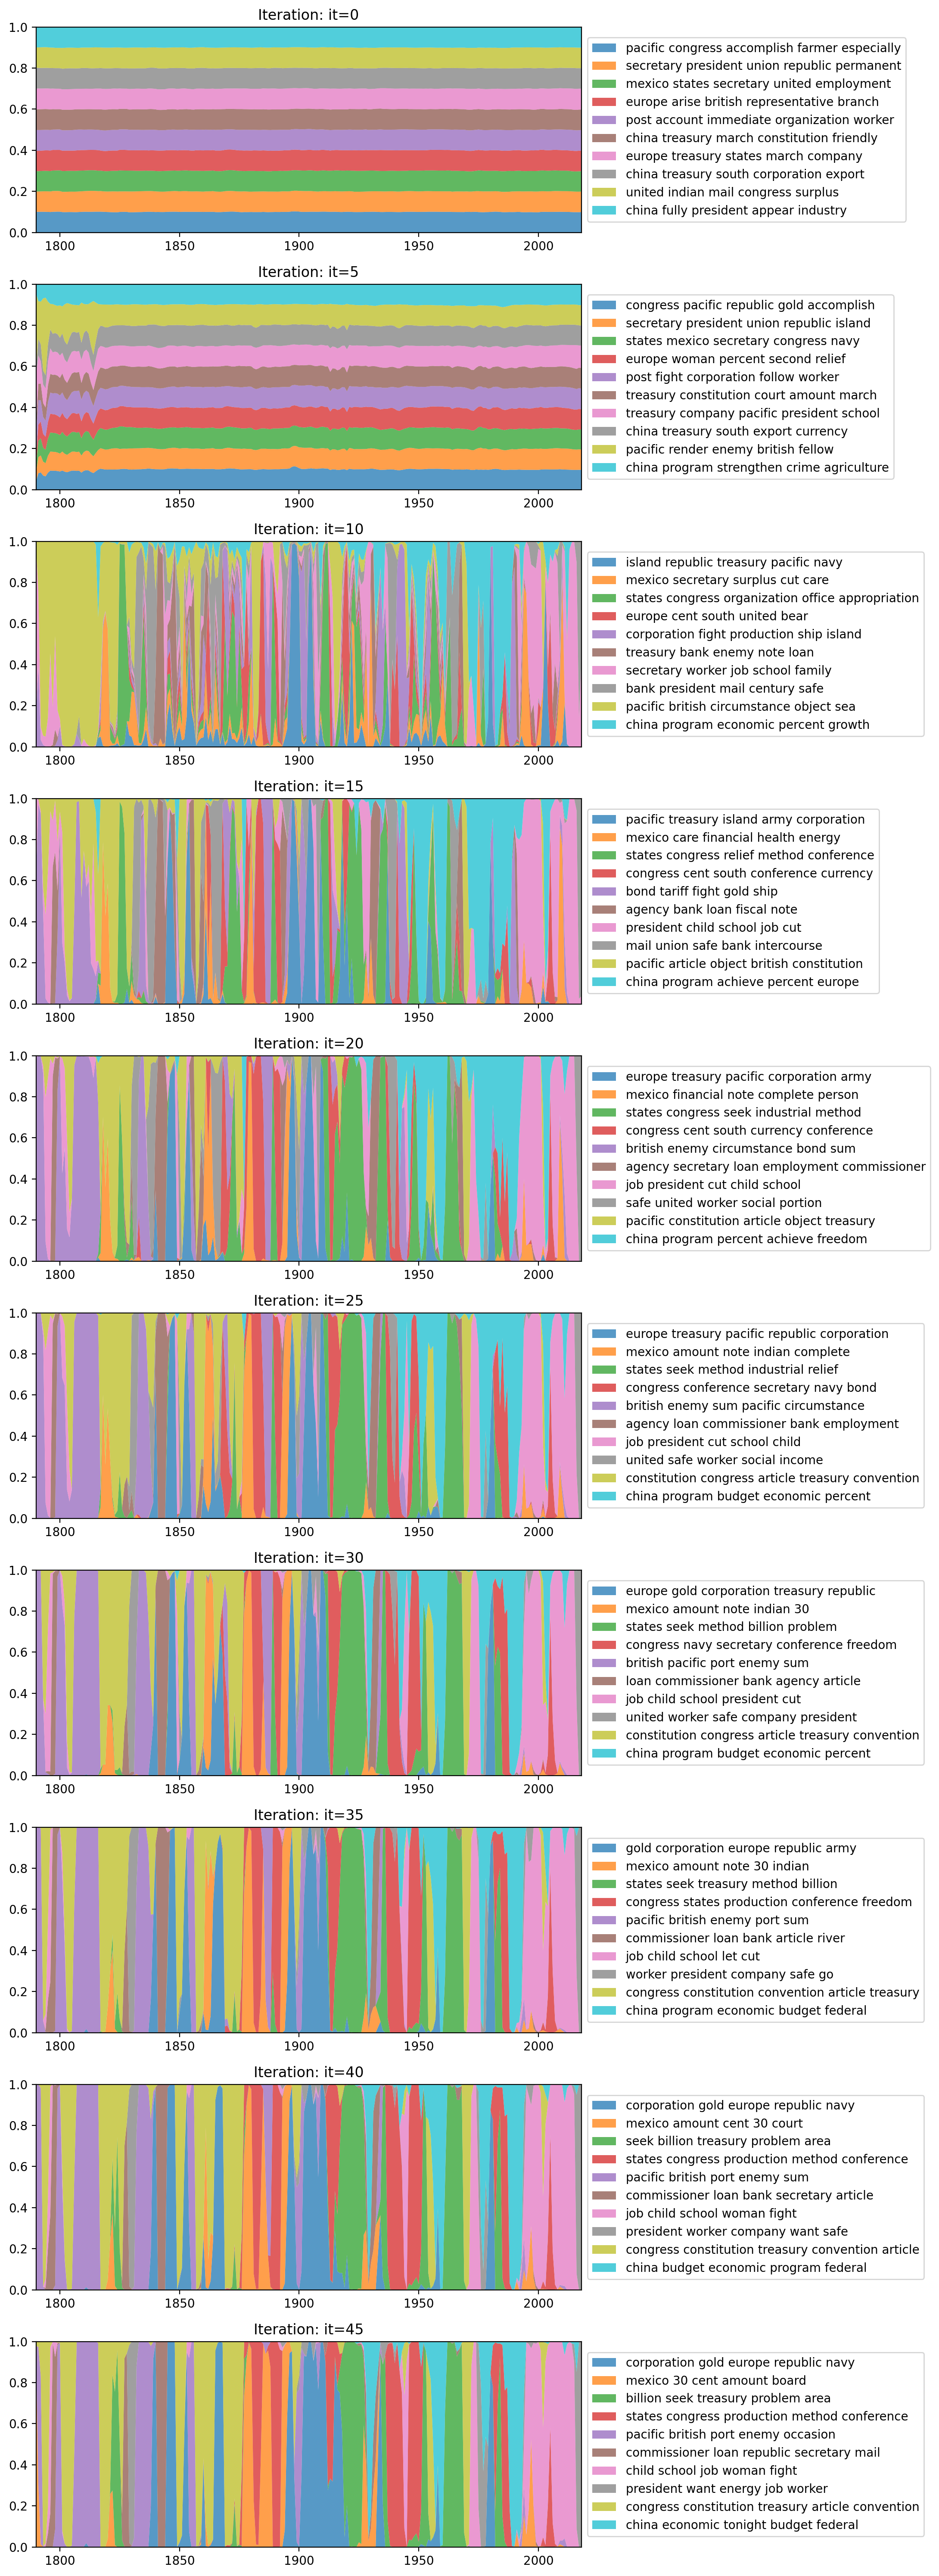

In [330]:
N_ITER = 50
VISUALISE = True
SHOW_EVERY = 5

prior_mean_single_doc = np.zeros(K)
prior_cov_single_doc = np.array([kernelmat([0], ["a"], [0], ["a"])[0, 0]]*K)

if VISUALISE:
    idxs = range(len(years))
    sorted_years, sorted_idxs = zip(*sorted(zip(years, idxs)))
    fig, ax = plt.subplots(nrows=int(N_ITER/SHOW_EVERY), figsize=(11, N_ITER/SHOW_EVERY*3), dpi=200)

# print(prior_cov_single_doc)
# i added
mask = document_feats.sum(axis=-1) != 0

m, lam = np.tile(prior_mean_single_doc, (num_docs,1)), np.tile(prior_cov_single_doc, (num_docs,1))

m_C, cov_C = np.zeros_like(m), np.zeros_like(lam)

for it in tqdm.trange(N_ITER):
#     big = np.zeros(gamma_tilde.shape)
#     mx = np.argmax(gamma_tilde, axis=-1)
#     idx_ij = np.meshgrid(np.arange(mx.shape[0]), np.arange(mx.shape[1]), indexing='ij')
#     idx = [*idx_ij, mx]
#     big[idx] = 1
#     big[~mask] = np.zeros(K)

#     n_dk = big.sum(axis=1)

#     for d in range(num_docs):
#         m[d], lam[d] = gp_data_likelihood(n_dk[d]+1, m[d], np.diag(lam[d]))
#     for d in range(num_docs):
#         alpha_tilde[d] = gauss2dir(m[d], lam[d])
    
    alpha_tilde = alpha + gamma_tilde.sum(1)
#     alpha = gamma_tilde.sum(1)
    
#     print(m[d].shape, lam[d].shape, alpha.shape)
#     for d in range(num_docs):
#         m_C[d], cov_C[d] = gp_data_likelihood(alpha[d], m[d], np.diag(lam[d]))
    
#     print(m_C.shape, cov_C.shape)
    
    gp_data_all = np.array([gp_data_likelihood(alpha_tilde[d], prior_mean_single_doc, np.diag(prior_cov_single_doc)) for d in range(num_docs)])
    gp_data = gp_data_all[:, 0, :].T.flatten()
    gp_data_noise = gp_data_all[:, 1, :].T.flatten()
    
#     print('gp_data, noise\n', gp_data, gp_data_noise)
    precision, adjusted_mean = compute_natural_params(gp_data, gp_data_noise)
#     print('Pm, Pcov\n', precision, adjusted_mean)
    
    m, cov = posterior_gp(years, precision, adjusted_mean)
    m = m.reshape((K, -1)).T
#     cov = extract_block_diag(cov, num_docs).transpose([1,2,0])
#     cov = np.diag(cov).reshape(K, -1).T
    cov = np.diag(cov).reshape(num_docs, -1)
#     print('m, cov\n', m, cov)
    
    alpha_tilde = np.array([gauss2dir(m[d,:], cov[d,:]) for d in range(num_docs)])
#     alpha_tilde = np.array([softmax(m[d,:]) for d in range(num_docs)])
#     print('Alpha\n',alpha_tilde)
#     print(alpha_tilde.shape)
#     break
    
    # Update beta_tilde
    # -----------------
    for k in range(K):
        prod = gamma_tilde[:, :, [k]] * document_feats 
        beta_tilde[k] = beta + prod.sum(axis=(0, 1))
        
    # Update gamma_tilde
    # ------------------
    for d in range(num_docs):
        for i in range(MAX_DOC_LEN):
            first = digamma(alpha_tilde[d])
            secnd = digamma(beta_tilde[:, document_feats[d, i].argmax()])
            third = digamma(beta_tilde.sum(1))            
            gamma_tilde[d, i] = np.exp(first + secnd - third)
            gamma_tilde[d, i] /= gamma_tilde[d, i].sum()
    
    if VISUALISE and it % SHOW_EVERY == 0:
        plot_proportions(
            alpha_tilde, beta_tilde, ax[int(it/SHOW_EVERY)], 
            title="Iteration: it=" + str(it), num_words_shown=5)

if VISUALISE:
    plt.tight_layout()
    plt.show()


## Looking at the topics

Below is a short snippet from assignment 10/11 which prints the most frequent words from each topic.
If the KTM iteration was successful, at least some of those topics should be meaningful. What do you notice?

In [331]:
NUM_FREQUENT_WORDS = 8

# Sort the document-topic distributions
E_doc_top_prop = alpha_tilde / alpha_tilde.sum(1, keepdims=True)
E_top_word_prop = beta_tilde / beta_tilde.sum(1, keepdims=True)  # Dirichlet expectations
E_top_word_prop_importance = E_top_word_prop / E_top_word_prop.sum(0, keepdims=True)
E_doc_top_prop = E_doc_top_prop[sorted_idxs, :]
curr_sum = 0

# Print words
for k, topic_word_dist in enumerate(E_top_word_prop_importance):  # For each topic
    idxs = topic_word_dist.argsort()[::-1][:NUM_FREQUENT_WORDS]
    print(f'Topic-{k+1}')
    print(' '.join([idx2word[idx] for idx in idxs]))
    # print(np.round(topic_word_dist[idxs], 2))
    print()

Topic-1
corporation gold europe navy republic army industrial efficiency

Topic-2
mexico 30 cent amount board conference indian department

Topic-3
billion seek area percent farmer achieve problem develop

Topic-4
states congress production bond method social farmer conference

Topic-5
pacific british port enemy render occasion portion minister

Topic-6
commissioner republic secretary mail article currency intercourse minister

Topic-7
job school child woman fight president help care

Topic-8
energy federal billion company job want percent cut

Topic-9
congress constitution article south states convention coast territory

Topic-10
china tonight economic federal budget area problem strength



Let us now take a final look at the document-topic proportion over time.

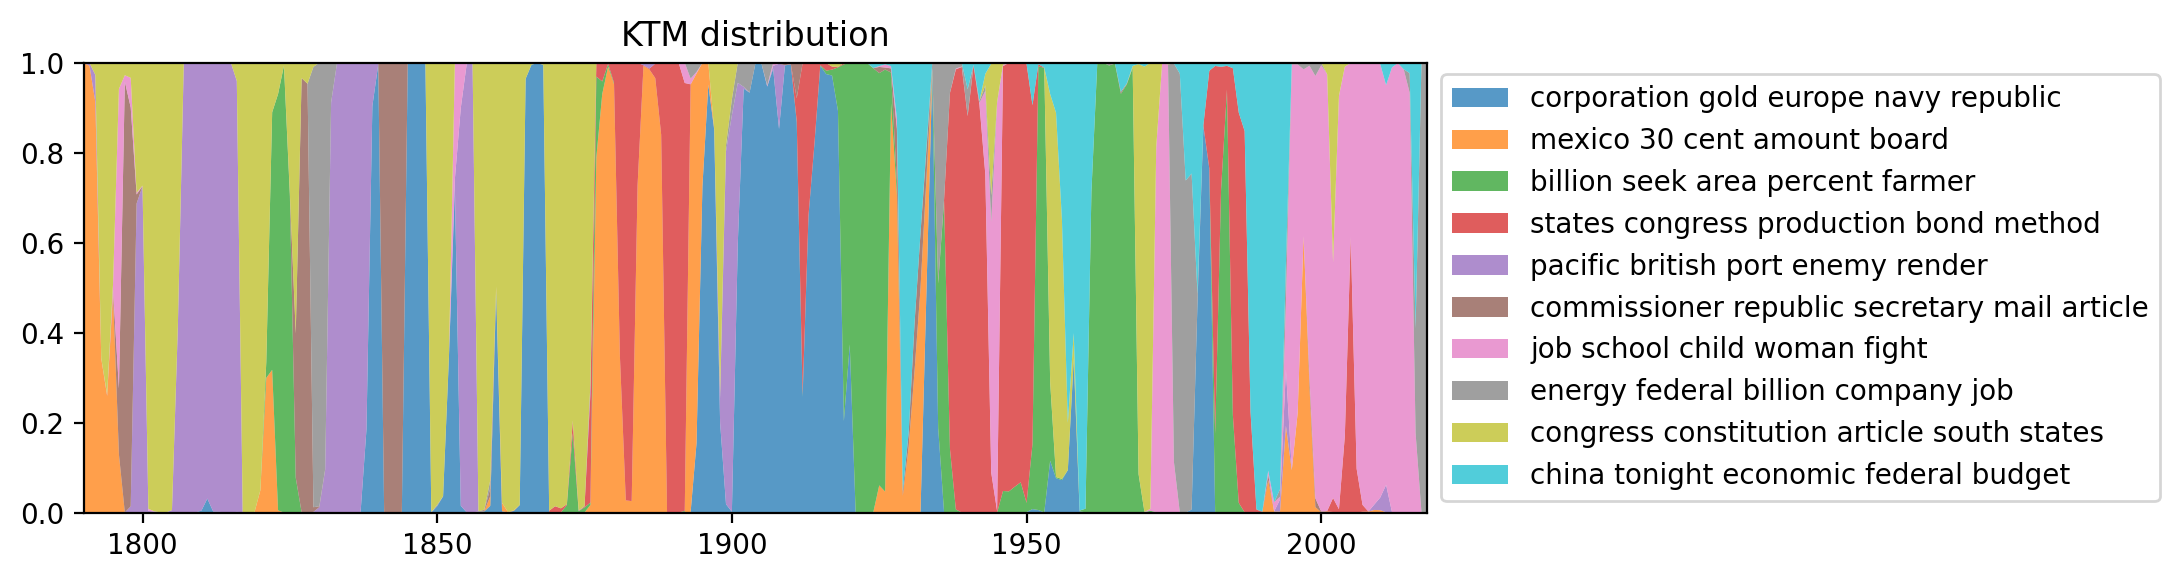

In [332]:
fig, ax = plt.subplots(nrows=1, figsize=(11, 3), dpi=200)

plot_proportions(
    alpha_tilde, beta_tilde, ax, 
    title="KTM distribution", num_words_shown=5)
plt.tight_layout()
plt.show()

If everything went smoothly until here, go ahead and try some other configurations. 

**TASK 3 (OPTIONAL):** Go back to the top and run the script with a different vocabulary sizes and/or different choices for the Gaussian process. What do you notice? 

### Summary

This concludes the last block of the practical exercises. On assignment 9, you practiced combining Dirichlets with Gaussian processes through the Laplace bridge; on assignment 10 some first LDA was put to a test with the Gibbs sampler; on assignment 11 the same was done with mean-field variational inference and on this, final assignment 11, you combined all of those algorithms and implemented Kernel Topic Models. 

Albeit this is only a simplified version of the method proposed in  https://arxiv.org/abs/1110.4713, we were able to recover structural knowledge about the change of topics in the SOTU speeches over time in a way that was not possible with plain LDA. For this to be successful, some careful choices of both, initialisation and Gaussian process were required.
What should be taken away from this exercise is that it is possible to integrate structural knowledge about the solution of a problem into many algorithms, for instance into LDA, by carefully deriving appropriate solutions.